# **Machine Learning with XGboost in Python**

Welcome to this code-along, where we will use XGBoost to predict booking cancellations with gradient boosting, a powerful machine learning technique! Through this, you'll learn how to create, evaluate, and tune XGBoost models efficiently. There will be time to answer any questions, so please add them!

## **The Dataset**

The session's dataset is a CSV file named `hotel_bookings_clean.csv`, which contains data on hotel bookings. 

### **Acknowledgements**
The dataset was downloaded on [Kaggle](https://www.kaggle.com/jessemostipak/hotel-booking-demand/). The data is originally from an article called [Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191) by Nuno Antonio, Ana de Almeida, and Luis Nunes. It was then cleaned by Thomas Mock and Antoine Bichat for [#TidyTuesday during the week of February 11th, 2020](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md). For the purposes of this code-along, it was further pre-processed to have cleaner ready-to-use features (e.g., dropping irrelevant columns, one-hot-encoding). The dataset has the following [license](https://creativecommons.org/licenses/by/4.0/).

### **Data Dictionary**

It contains the **53 columns**:

_For binary variables: `1` = true and `0` = false._

#### **Target** 
- `is_canceled`: Binary variable indicating whether a booking was canceled

#### **Features** 
- `lead time`: Number of days between booking date and arrival date
- `arrival_date_week_number`, `arrival_date_day_of_month`, `arrival_date_month`: Week number, day date, and month number of arrival date 
- `stays_in_weekend_nights`, `stays_in_week_nights`: Number of weekend nights (Saturday and Sunday) and weeknights (Monday to Friday) the customer booked
- `adults`,`children`,`babies`: Number of adults, children, babies booked for the stay
- `is_repeated_guest`: Binary variable indicating whether the customer was a repeat guest 
- `previous_cancellations`: Number of prior bookings that were canceled by the customer
- `previous_bookings_not_canceled`: Number of prior bookings that were not canceled by the customer
- `required_car_parking_spaces`: Number of parking spaces requested by the customer
- `total_of_special_requests`: Number of special requests made by the customer
- `avg_daily_rate`: Average daily rate, as defined by dividing the sum of all lodging transactions by the total number of staying nights
- `booked_by_company`: Binary variable indicating whether a company booked the booking
- `booked_by_agent`: Binary variable indicating whether an agent booked the booking
- `hotel_City`: Binary variable indicating whether the booked hotel is a "City Hotel"
- `hotel_Resort`: Binary variable indicating whether the booked hotel is a "Resort Hotel"
- `meal_BB`: Binary variable indicating whether a bed & breakfast meal was booked 
- `meal_HB`: Binary variable indicating whether a half board meal was booked
- `meal_FB`: Binary variable indicating whether a full board meal was booked 
- `meal_No_meal`: Binary variable indicating whether there was no meal package booked 
- `market_segment_Aviation`, `market_segment_Complementary`, `market_segment_Corporate`, `market_segment_Direct`, `market_segment_Groups`, `market_segment_Offline_TA_TO`, `market_segment_Online_TA`, `market_segment_Undefined`: Indicates market segment designation with a value of `1`. "TA"= travel agent, "TO"= tour operators
- `distribution_channel_Corporate`, `distribution_channel_Direct`, `distribution_channel_GDS`, `distribution_channel_TA_TO`, `distribution_channel_Undefined`: Indicates booking distribution channel with a value of `1`. "TA"= travel agent, "TO"= tour operators, "GDS" = Global Distribution System
- `reserved_room_type_A`,`reserved_room_type_B`, `reserved_room_type_C`,`reserved_room_type_D`, `reserved_room_type_E`, `reserved_room_type_F`, `reserved_room_type_G`, `reserved_room_type_H`, `reserved_room_type_L`: Indicates code of room type reserved with a value of `1`. Code is presented instead of designation for anonymity reasons
- `deposit_type_No_Deposit`: Binary variable indicating whether a deposit was made
- `deposit_type_Non_Refund`: Binary variable indicating whether a deposit was made in the value of the total stay cost
- `deposit_type_Refundable`: Binary variable indicating whether a deposit was made with a value under the total stay cost 
- `customer_type_Contract`: Binary variable indicating whether the booking has an allotment or other type of contract associated to it 
- `customer_type_Group`: Binary variable indicating whether the booking is associated to a group 
- `customer_type_Transient`: Binary variable indicating whether the booking is not part of a group or contract, and is not associated to other transient booking
- `customer_type_Transient-Party`: Binary variable indicating whether the booking is transient, but is associated to at least another transient booking

---



## **1. Getting to know our data**

Let's get to know our columns and split our data into features and labels!

In [2]:
# Import libraries
import pandas as pd
import xgboost as xgb # XGBoost typically uses the alias "xgb"
import numpy as np

In [3]:
# Read in the dataset
bookings = pd.read_csv('hotel_bookings_clean.csv')

# List out our columns
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119210 non-null  int64  
 1   lead_time                       119210 non-null  int64  
 2   arrival_date_week_number        119210 non-null  int64  
 3   arrival_date_day_of_month       119210 non-null  int64  
 4   arrival_date_month              119210 non-null  int64  
 5   stays_in_weekend_nights         119210 non-null  int64  
 6   stays_in_week_nights            119210 non-null  int64  
 7   adults                          119210 non-null  int64  
 8   children                        119206 non-null  float64
 9   babies                          119210 non-null  int64  
 10  is_repeated_guest               119210 non-null  int64  
 11  previous_cancellations          119210 non-null  int64  
 12  previous_booking

It looks like we have 53 columns with 119,210 rows. All the datatypes are numeric and ready for use.

In [4]:
# Take a closer look at column distributions
bookings.describe()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119206.000000,119210.000000,...,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000
mean,0.370766,104.109227,27.163376,15.798717,6.552051,0.927053,2.499195,1.859206,0.104047,0.007961,...,0.017549,0.005042,0.000050,0.876277,0.122364,0.001359,0.034158,0.004815,0.750575,0.210452
std,0.483012,106.875450,13.601107,8.781070,3.089796,0.995117,1.897106,0.575186,0.398842,0.097509,...,0.131305,0.070825,0.007094,0.329266,0.327707,0.036839,0.181636,0.069223,0.432682,0.407631
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,8.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,69.000000,28.000000,16.000000,7.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,161.000000,38.000000,23.000000,9.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,737.000000,53.000000,31.000000,12.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

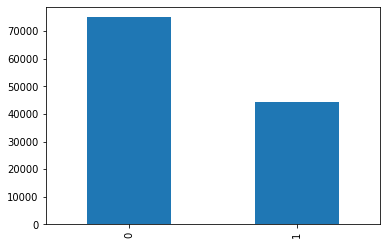

In [5]:
# Plot cancellation counts to visualize proportion of not cancelled and cancelled
bookings['is_canceled'].value_counts().plot(kind='bar')

Remember for our binary variables, like `is_canceled`, `1` = true and `0` = false.

In [6]:
# Get an exact percentage of not cancelled and cancelled
bookings['is_canceled'].value_counts()/bookings['is_canceled'].count()*100

0    62.923412
1    37.076588
Name: is_canceled, dtype: float64

### **Splitting data**
Let's split our label and features so we can get to building models! The first column is our target label `is_canceled`. The rest are features.

In [7]:
# Define X and y
X, y = bookings.iloc[:,1:], bookings.iloc[:,0]

## **2. Your First XGBoost Classifier**

XGBoost has a  [scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn), which is useful if you want to use different scikit-learn classes and methods on an XGBoost model (e.g.,`predict()`, `fit()`).  In this section, we'll try the API out with the `xgboost.XGBClassifier()` class and get a baseline accuracy for the rest of our work. So that our results are reproducible, we'll set the `random_state=123`.

As a reminder, gradient boosting sequentially trains weak learners where each weak learner tries to correct its predecessor's mistakes. First, we'll instantiate a simple XGBoost classifier without changing any of the other parameters, and we'll inspect the parameters that we haven't touched.

In [8]:
from sklearn.model_selection import train_test_split

# Train and test split using sklearn
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.33, random_state=123)

# Instatiate a XGBClassifier 
xgb_clf = xgb.XGBClassifier(random_state=123)

# Inspect the parameters
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

There's a couple of things to note:
- The `booster` parameter is `gbtree`.  This means the weak learners, or boosters, are decision trees in this model. `gbtree` is the default, and we will keep it this way.
- The `objective` function, or loss function, is defined as `binary:logistic`. The objective function quantifies how far off a prediction is from the actual results. We want to minimize this to have the smallest possible loss. `binary:logistic` is the default for classifiers. `binary:logistic` outputs the actual predicted probability of the positive class (in our case, that a booking is cancelled).
- `n_estimators` is the number of gradient boosted trees we want in our model. It's equivalent to the number of boosting rounds. For our purposes, we don't want too many boosting rounds, or training will take too long. **Let's lower it from 100 to 10**.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/n_estimators.png?raw=true" width = "70%"> 
</p>

<br>

- `max_depth` is the maximum tree depth allowed. Tree depth is the length of the longest path from the root node to a leaf node. Making this too high will give our model more variance, or more potential to overfit. Similar to `n_estimators`, the more we increase this, the longer our training period will be. **Let's keep this at 3**.


<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/max_depth.png?raw=true" width = "25%"> 
</p>

- For our `eval_metric` (evaluation metric for validation data), we will use `error` as defined by [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):

> Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.

In [11]:
## Set n_estimators to 10 
xgb_clf.set_params(n_estimators=10)

## Set max_depth to 3
xgb_clf.set_params(max_depth=3)

# Set the evaluation metric to error
xgb_clf.set_params(eval_metric='error')

# Fit it to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

We are going to use **accuracy** as our metric for this problem since we only have two classes, and the smallest class takes ~37% of the data. To calculate accuracy, we need to count the correctly predicted data points and divide it by the total number of data points.

In [12]:
# Calculate the accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]

# Print the baseline accuracy
print("Baseline accuracy:", accuracy)

Baseline accuracy: 0.8062785968479919


### **Visualizing your tree**

`XGBoost` has two handy visualization functions for interpreting results.

The first is `plot_importance()`  which plots feature importance, meaning, how predictive each feature is for the target variable. It takes in the fitted XGBoost model.


#### **Plotting feature importance**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

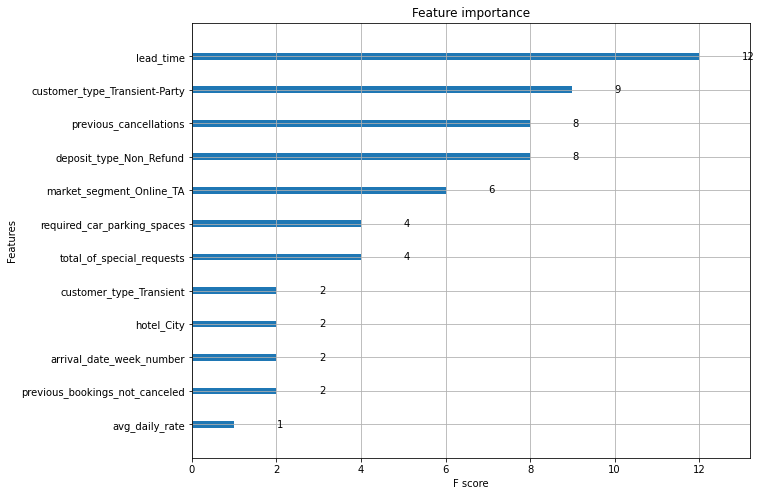

In [13]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

# Plot feature importance
xgb.plot_importance(xgb_clf)

How is importance calculated? Here's an excerpt from the [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting):

> **importance_type (str, default "weight") –**
> How the importance is calculated: either “weight”, “gain”, or “cover”
> - ”weight” is the number of times a feature appears in a tree
> - ”gain” is the average gain of splits which use the feature
> - ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

We'll focus on the first two. Gain is a way to quantify how much a feature contributes to improving accuracy. Let's try out `gain` to see how it differs from `weight`.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

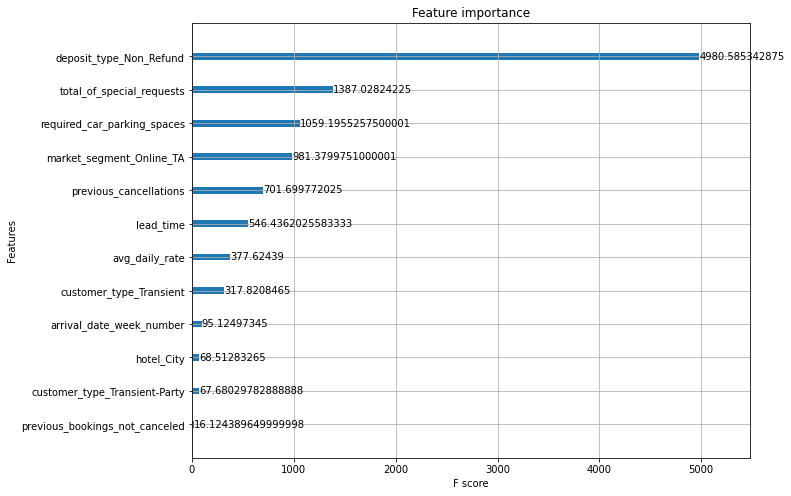

In [14]:
# Plot gain instead of weight
xgb.plot_importance(xgb_clf, importance_type="gain")

Here we see the ordering of features differs quite a bit between `gain` and `weight`! This implies that (1) feature importance can be subjective, and (2) the number of appearances a feature has on a tree is not necessarily correlated to how much gain it brings. For example, a binary variable has less of a chance to appear as many times as a continuous variable on a tree, since there are only two outputs. However, it can still be a powerful feature.

#### **Plotting a decision tree from your model**

The second handy visualization function is `plot_tree()` which visually generates a decision tree in your model. Remember, there are multiple trees in the model.

It takes in the fitted XGBoost model, and with the `num_trees` parameter, you can indicate which tree you want to see. For example, if I have `n_estimator=3`, I can set the `num_trees` parameter as `0`, `1`, or `2` to see the first, second, or third tree, respectively.

<AxesSubplot:>

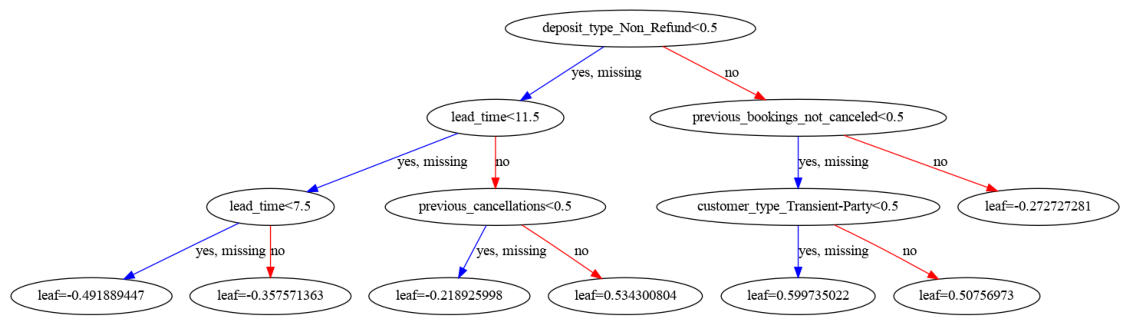

In [15]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8)

# Plot the first tree
xgb.plot_tree(xgb_clf, num_trees=0)

The leaf output is the raw score. It's converted to a probability at the end of training.

There's a parameter called `rankdir`. We can set it to `LR` so the decision tree builds left to right, as opposed to top to bottom.

<AxesSubplot:>

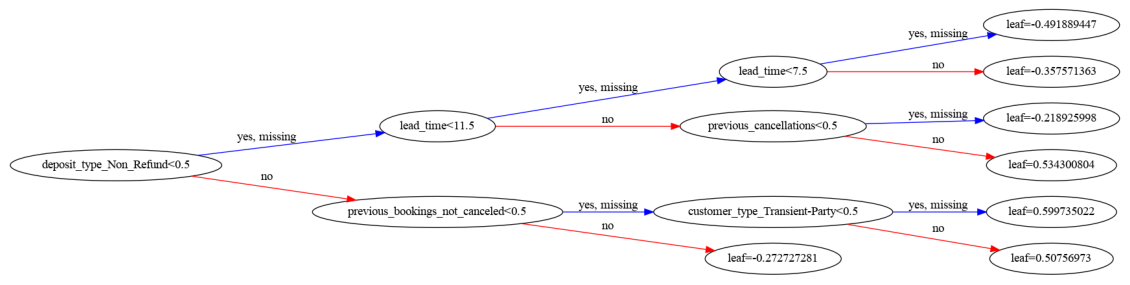

In [16]:
# Plot the last tree
xgb.plot_tree(xgb_clf, num_trees=0, rankdir='LR')

---
<center><h1> Q&A 1</h1> </center>

---

## **3. Digging into Parameters**

There are many parameters for our tree booster. We can see this in the documentation for [parameters for tree booster](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster).

In this section, we'll take a look at several important parameters and understand what they do.

For this session's purpose, we'll use `XGBClassifier()` with **25 boosting** rounds to avoid long training times. 

In [17]:
from sklearn.metrics import accuracy_score

# Instantiate the XGBClassifier with 25 boosting rounds and error evaluation metric
xgb_clf = xgb.XGBClassifier(n_estimators=25, eval_metric='error', random_state=123)

### **Max depth**

_From XGBoost docs:_
> Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/max_depth.png?raw=true" width = "35%"> 
</p>

Let's see what happens when we increase the `max_depth` from 3 to 10.


In [18]:
# Set max_depth to 10
xgb_clf.set_params(max_depth=10)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8367310625317743

### **colsample_bytree**

_From XGBoost docs:_

> The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

Essentially, this lets us limit the number of columns used when constructing each tree. This adds randomness, making the model more robust to noise. The default is 1 (i.e. all the columns), let's try a smaller value.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/colsample_bytree.gif?raw=true" width = "55%"> 
</p>

In [19]:
# Set colsample_bytree to 0.5 
xgb_clf.set_params(colsample_bytree=0.5)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8378495170310117

We can also limit the number of columns used by every depth level or node of our tree.

_From XGBoost docs:_

> `colsample_bylevel` is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.

> `colsample_bynode` is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.

### **subsample**

_From XGBoost docs:_

> - Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees and this will prevent overfitting. 
> - Subsampling will occur once in every boosting iteration.
> - range: (0,1]

Default is 1, let's try 0.75. 

This means each of our trees will get a random sampling of 75% of our training data. Each tree will train on different portions of data which adds randomness (similar to `colsample_bytree`). 

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/subsample.gif?raw=true" width = "55%"> 
</p>

However, we don't want this too low if we don't have many trees, because our model will underfit from not seeing as much data.

In [20]:
# Set subsample to 0.75 
xgb_clf.set_params(subsample=0.75)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8364768683274021

### **gamma**

_From XGBoost docs:_
> - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
> - range: [0,∞]


This decides whether a node will split based on the expected loss reduction after the split. `gamma` represents the minimum loss reduction required for a node to split.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/gamma.png?raw=true" width = "45%"> 
</p>

Increasing `gamma` = less splits = less complexity

The default is 0, so in our case, nodes have always split until the maximum depth. Let's increase it to 0.25.




In [21]:
# Set gamma to .25 
xgb_clf.set_params(gamma=0.25)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8373665480427046

### **Learning Rate (aka eta)**

_From XGBoost docs:_
> - Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
> - range: [0,1]

The learning rate affects how quickly a model learns.

Gradient boosting works by sequentially adding weak learners to the model. Each new weak learner attempts to correct the residual errors from the preceding trees. This make the model very susceptible to overfitting. Learning rate can help slow down learning by shrinking the resulting weights of the current tree before passing them on to the next tree.

The learning rate of our model defaults to 0.3. What happens if we change it to 0.1?

In [22]:
# Set learning rate to .1
xgb_clf.set_params(learning_rate=0.1)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8272241992882562

The learning rate and the number of trees should be tuned together. If we decrease the learning rate, we need to make sure we have enough trees to learn something and avoid severely underfitting. **Therefore, a low learning rate will require more boosting rounds.**

### **reg_alpha**

_From XGBoost docs:_
> L1 regularization term on weights. Increasing this value will make model more conservative.

L1 is often referred to as **lasso regression**. It's a foundational regularization technique, meaning it aims to reduce overfitting by discouraging complex models. In the case of gradient boosting, L1 does this by adding penalties on leaf weights. Increasing `reg_alpha` drives base learners' leaf weights towards 0.

Default is 0, meaning there is no alpha regularization in our model currently. Let's activate L1 with a value of `0.01`.

In [23]:
# set reg_alpha to .1 
xgb_clf.set_params(reg_alpha=0.01)

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
preds = xgb_clf.predict(X_test)

# Compute the accuracy
accuracy_score(y_test, preds)

0.8271225216065073

**L2**, aka ridge regression, is also available with the parameter `reg_lambda`. L2 is known for having smoother penalty then L1. This means leaf weights smoothly decrease rather with less risk of sparsity in the leaf weights. So, make sure to try our different regularization techniques! 

Let's take a look at our resulting parameters after we manually changed them.

In [24]:
# Print the model parameters
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0.25,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 25,
 'n_jobs': 16,
 'num_parallel_tree': 1,
 'random_state': 123,
 'reg_alpha': 0.01,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.75,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'error'}

There are a lot of possible parameters combinations. We can't manually tune and pick them.

## **4. Hyperparameter tuning with Random Search**

Grid search and random search are the most popular methods for hyperparameter tuning. However, grid search can get computationally expensive if you are searching over a large hyperparameter space and dealing with multiple hyperparameters. This is why we'll use random search because it doesn't try all the hyperparameter values. In random search, a fixed number of hyperparameter settings is sampled from specified probability distributions.

XGBoost doesn't have a built-in gridsearch function, so we need to use `scikit-learn`'s [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). This means we'll have to use `XGBClassifier()` because it's `scikit-learn` compatible.


<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/randomized_search_1.gif?raw=true" width = "50%"> 
</p>


<br>

The `RandomizedSearchCV()` function takes in the following arguments:

- `estimator`: The estimator being fit, here it's XGBoost.
- `param_distributions`: Unlike `params` - this is the distribution of possible hyperparameters to use.
- `cv`: Number of cross-validation iterations
- `n_iter`: Number of hyperparameter combinations to choose from
- `verbose`: Prints more output

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Define a parameter grid
rs_param_grid = {
    # max_depth: values from 3 to 12
    'max_depth': list((range(3,12))),
    # alpha: values 0, .001, .01, .1
    'alpha': [0,0.001, 0.01,0.1,1],
    # subsample: values 0.25,0.5,0.75, 1
    'subsample': [0.5,0.75,1],
    # learning rate: ten values between 0.01 - 0.5
    'learning_rate': np.linspace(0.01,0.5, 10),
    # n_estimators: values 10, 25, 40
    'n_estimators': [10, 25, 40]
    }


# Insantiate XGBoost Clasifier 
xgb_clf = xgb.XGBClassifier(eval_metric='error', random_state=123)

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf,param_distributions=rs_param_grid, 
                                cv=3, n_iter=5, verbose=2, random_state=123)

# Train the model on the training set
xgb_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", xgb_rs.best_params_)
print("Best accuracy found: ", xgb_rs.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   2.2s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   2.2s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   1.8s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   4.2s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   2.3s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   1.2s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   2.3s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   2.9s
[CV] END